# 3.3 — Leveraging (Safe) LLM-style Augmentation to Strengthen Models

**Mục tiêu:** tái hiện ý tưởng 3.3: *augment training data bằng biến thể “obfuscated”* để tăng độ bền (robustness) khi test trên obfuscated XSS.

> Lưu ý an toàn: notebook này tạo **biến thể dạng “obfuscation-like” chỉ bằng biến đổi chuỗi** (URL-encode/Base64/HTML-entities/...), không tạo payload khai thác chạy được.


In [1]:
from pathlib import Path
import re, random, base64, urllib.parse
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt


In [2]:
# ----------------------------
# 1) Load datasets
# ----------------------------
DATA_DIR = Path("./Dataset")

TRAIN_CSV = DATA_DIR / "_outputs_train_val_test/train.csv"
OBF_TEST_MULTI = DATA_DIR / "obfuscated_test_xss.csv"  # đã tạo ở 3.2

train_df = pd.read_csv(TRAIN_CSV)
obf_df = pd.read_csv(OBF_TEST_MULTI)

def normalize_text(s: str) -> str:
    s = str(s).lower().replace("\n"," ").replace("\r"," ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

train_df["payload"] = train_df["payload"].map(normalize_text)
obf_df["payload_obfuscated"] = obf_df["payload_obfuscated"].map(normalize_text)

train_df.shape, obf_df.shape


((13938, 2), (6800, 6))

In [3]:
# ----------------------------
# 2) Build augmented training set (3.3 idea)
#    - keep originals
#    - for malicious: add N_AUG_PER_MAL obfuscation-like variants
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

N_AUG_PER_MAL = 3

def b64_encode_only(s: str) -> str:
    return base64.b64encode(s.encode("utf-8", errors="ignore")).decode("ascii")

def url_encode_only(s: str) -> str:
    return urllib.parse.quote(s, safe="")

def html_entity_encode(s: str) -> str:
    return (s.replace("&","&amp;")
             .replace("<","&lt;")
             .replace(">","&gt;")
             .replace('"',"&quot;")
             .replace("'","&#x27;"))

def whitespace_noise(s: str, p: float = 0.12) -> str:
    out=[]
    for ch in s:
        out.append(ch)
        if ch in ['<','>','=',"'",'"','(',')',';','/','+','-','*',',',':'] and random.random()<p:
            out.append(" " * random.randint(1,2))
    return "".join(out)

def comment_marker(s: str, p: float = 0.02) -> str:
    out=[]
    for ch in s:
        out.append(ch)
        if ch.isalpha() and random.random()<p:
            out.append("/*OBF*/")
    return "".join(out)

def reverse_chunks(s: str) -> str:
    if len(s) < 12:
        return s[::-1]
    k = max(3, min(8, len(s)//10))
    chunks = [s[i:i+k] for i in range(0, len(s), k)]
    return "".join(chunks[::-1])

def double_urlencode(s: str) -> str:
    return url_encode_only(url_encode_only(s))

TRANSFORMS = {
    "urlencode": url_encode_only,
    "double_urlencode": double_urlencode,
    "base64": b64_encode_only,
    "html_entities": html_entity_encode,
    "whitespace_noise": whitespace_noise,
    "comment_marker": comment_marker,
    "reverse_chunks": reverse_chunks,
}

# weights (sum=1)
probs = {
    "urlencode": 0.18,
    "double_urlencode": 0.12,
    "base64": 0.18,
    "html_entities": 0.14,
    "whitespace_noise": 0.16,
    "comment_marker": 0.12,
    "reverse_chunks": 0.10,
}
names = list(TRANSFORMS.keys())
pvals = np.array([probs[n] for n in names], dtype=float)
pvals = pvals / pvals.sum()

def weighted_sample_without_replacement(k: int):
    k=min(k, len(names))
    chosen=[]
    available=names.copy()
    for _ in range(k):
        w = np.array([pvals[names.index(a)] for a in available], dtype=float)
        w = w / w.sum()
        pick = np.random.choice(available, p=w)
        chosen.append(pick)
        available.remove(pick)
    return chosen

rows=[]
for _, r in train_df.iterrows():
    payload = r["payload"]
    label = int(r["label"])
    rows.append({"payload": payload, "label": label, "src":"orig", "technique":"none"})
    if label == 1:
        for t in weighted_sample_without_replacement(N_AUG_PER_MAL):
            rows.append({"payload": TRANSFORMS[t](payload), "label": 1, "src":"aug", "technique": t})

train_aug = pd.DataFrame(rows)

print("Original train:", train_df.shape, "Augmented train:", train_aug.shape)
print(train_aug["src"].value_counts())
print(train_aug["label"].value_counts())


Original train: (13938, 2) Augmented train: (29751, 4)
src
aug     15813
orig    13938
Name: count, dtype: int64
label
1    21084
0     8667
Name: count, dtype: int64


In [4]:
# ----------------------------
# 3) Train models on augmented data (same 4 models)
# ----------------------------
RANDOM_STATE = 42
TOP_K = 500  # chi2 features for tree-based models

# BoW
vec = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
X_train = vec.fit_transform(train_aug["payload"])
y_train = train_aug["label"].astype(int).to_numpy()

# chi2
selector = SelectKBest(score_func=chi2, k=min(TOP_K, X_train.shape[1]))
X_train_k = selector.fit_transform(X_train, y_train)

models = {
    "Logistic Regression (Aug)": ("full", LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced", random_state=RANDOM_STATE)),
    "Linear SVM (Aug)": ("full", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE)),
    f"Decision Tree (Aug, chi2 k={selector.k})": ("k", DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE)),
    # RF is heavier; start with 100 trees for speed
    f"Random Forest (Aug, chi2 k={selector.k})": ("k", RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE)),
}

fitted={}
for name,(space,clf) in models.items():
    clf.fit(X_train if space=="full" else X_train_k, y_train)
    fitted[name]=(space,clf)

print("Trained:", list(fitted.keys()))


Trained: ['Logistic Regression (Aug)', 'Linear SVM (Aug)', 'Decision Tree (Aug, chi2 k=500)', 'Random Forest (Aug, chi2 k=500)']


In [5]:
# ----------------------------
# 4) Evaluate on obfuscated multi-variant test
#    (A) Mean over all variants
#    (B) Worst-case per sample_id
#    (C) Per-technique breakdown
# ----------------------------
X_obf_full = vec.transform(obf_df["payload_obfuscated"])
X_obf_k = selector.transform(X_obf_full)
y_obf = obf_df["label"].astype(int).to_numpy()

def metric_pack(y_true,y_pred):
    return dict(
        acc=accuracy_score(y_true,y_pred),
        prec=precision_score(y_true,y_pred, zero_division=0),
        rec=recall_score(y_true,y_pred, zero_division=0),
        f1=f1_score(y_true,y_pred, zero_division=0),
    )

# A) Mean
pred_cache={}
mean_rows=[]
for name,(space,clf) in fitted.items():
    y_pred = clf.predict(X_obf_full if space=="full" else X_obf_k).astype(int)
    pred_cache[name]=y_pred
    mean_rows.append({"model": name, **metric_pack(y_obf,y_pred)})
df_mean = pd.DataFrame(mean_rows).sort_values("f1", ascending=False)

# B) Worst-case per sample_id
tmp_base = obf_df[["sample_id","label"]].copy()
worst_rows=[]
for name,y_pred in pred_cache.items():
    tmp = tmp_base.copy()
    tmp["pred"]=y_pred
    grp = tmp.groupby("sample_id", as_index=False).agg(
        y_true=("label","max"),
        y_pred=("pred","min"),
        n=("pred","size")
    )
    worst_rows.append({"model": name, **metric_pack(grp["y_true"], grp["y_pred"]), "samples":len(grp), "avg_variants":grp["n"].mean()})
df_worst = pd.DataFrame(worst_rows).sort_values("f1", ascending=False)

# C) Per-technique
benign_idx = np.where((obf_df["label"]==0).to_numpy())[0]
techniques = sorted([t for t in obf_df["technique"].unique().tolist() if t!="none"])
tech_rows=[]
for name,y_pred_all in pred_cache.items():
    for t in techniques:
        mal_idx = np.where(((obf_df["label"]==1) & (obf_df["technique"]==t)).to_numpy())[0]
        idx = np.concatenate([benign_idx, mal_idx])
        tech_rows.append({
            "model": name, "technique": t, "n_malicious": len(mal_idx),
            **metric_pack(y_obf[idx], y_pred_all[idx]),
            "mal_recall": recall_score(y_obf[mal_idx], y_pred_all[mal_idx], zero_division=0) if len(mal_idx)>0 else np.nan
        })
df_tech = pd.DataFrame(tech_rows)

print("=== Mean over variants ===")
print(df_mean.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print("\n=== Worst-case per sample_id ===")
print(df_worst.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


=== Mean over variants ===
                          model    acc   prec    rec     f1
               Linear SVM (Aug) 0.9896 0.9858 0.9982 0.9920
      Logistic Regression (Aug) 0.9893 0.9847 0.9989 0.9917
Random Forest (Aug, chi2 k=500) 0.9869 0.9812 0.9989 0.9900
Decision Tree (Aug, chi2 k=500) 0.9844 0.9811 0.9950 0.9880

=== Worst-case per sample_id ===
                          model    acc   prec    rec     f1  samples  avg_variants
               Linear SVM (Aug) 0.9822 0.9586 0.9959 0.9769     3872        1.7562
      Logistic Regression (Aug) 0.9814 0.9555 0.9973 0.9759     3872        1.7562
Random Forest (Aug, chi2 k=500) 0.9775 0.9456 0.9980 0.9711     3872        1.7562
Decision Tree (Aug, chi2 k=500) 0.9742 0.9452 0.9891 0.9666     3872        1.7562


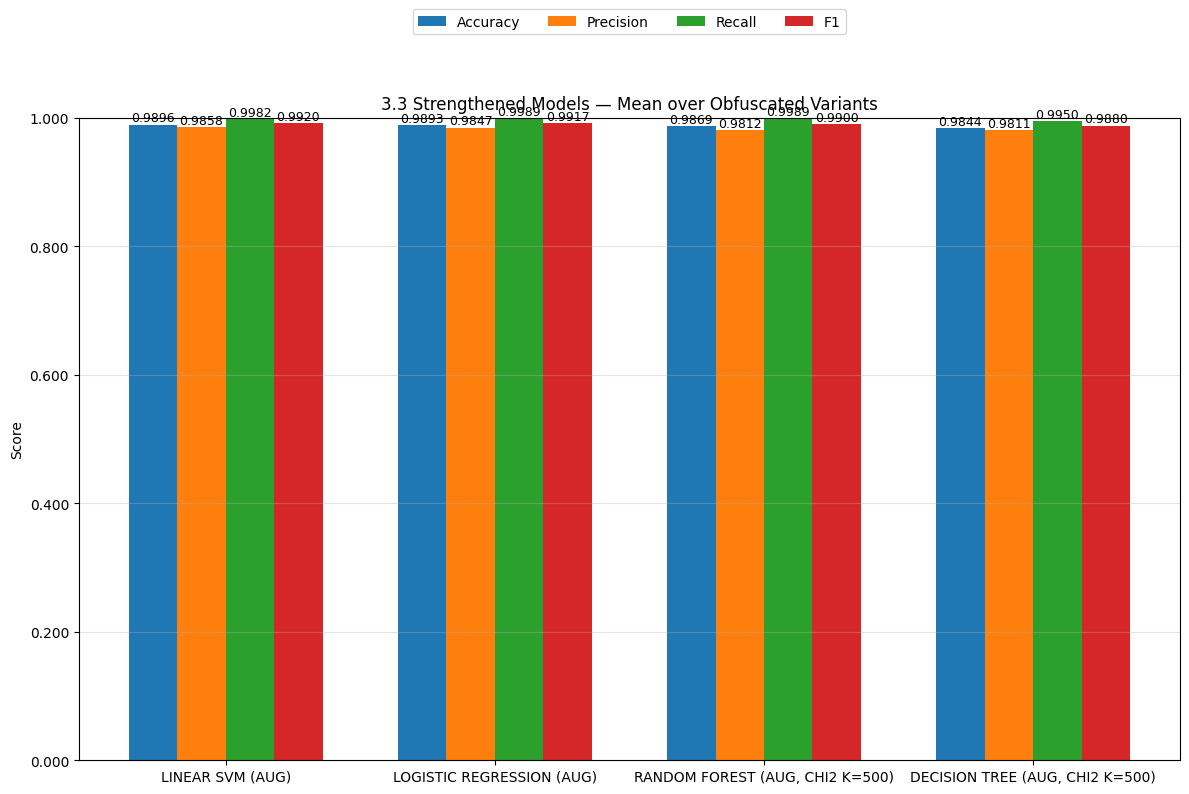

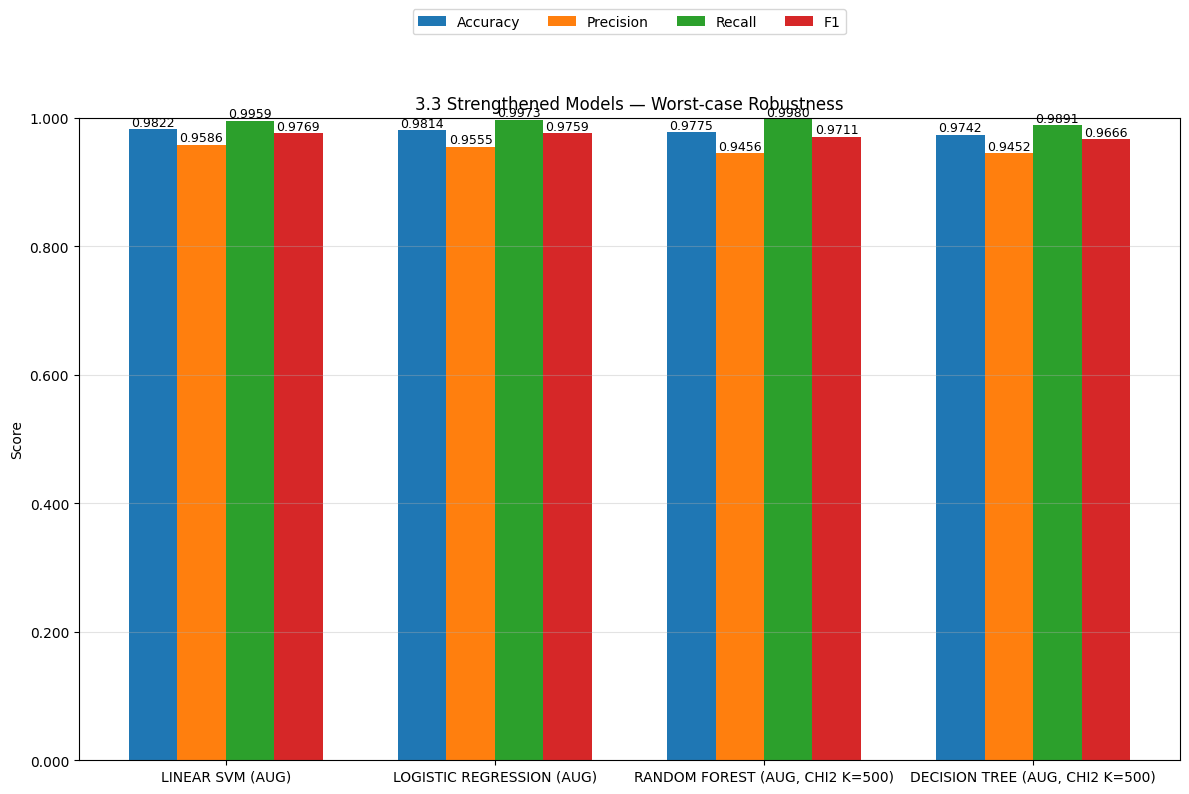

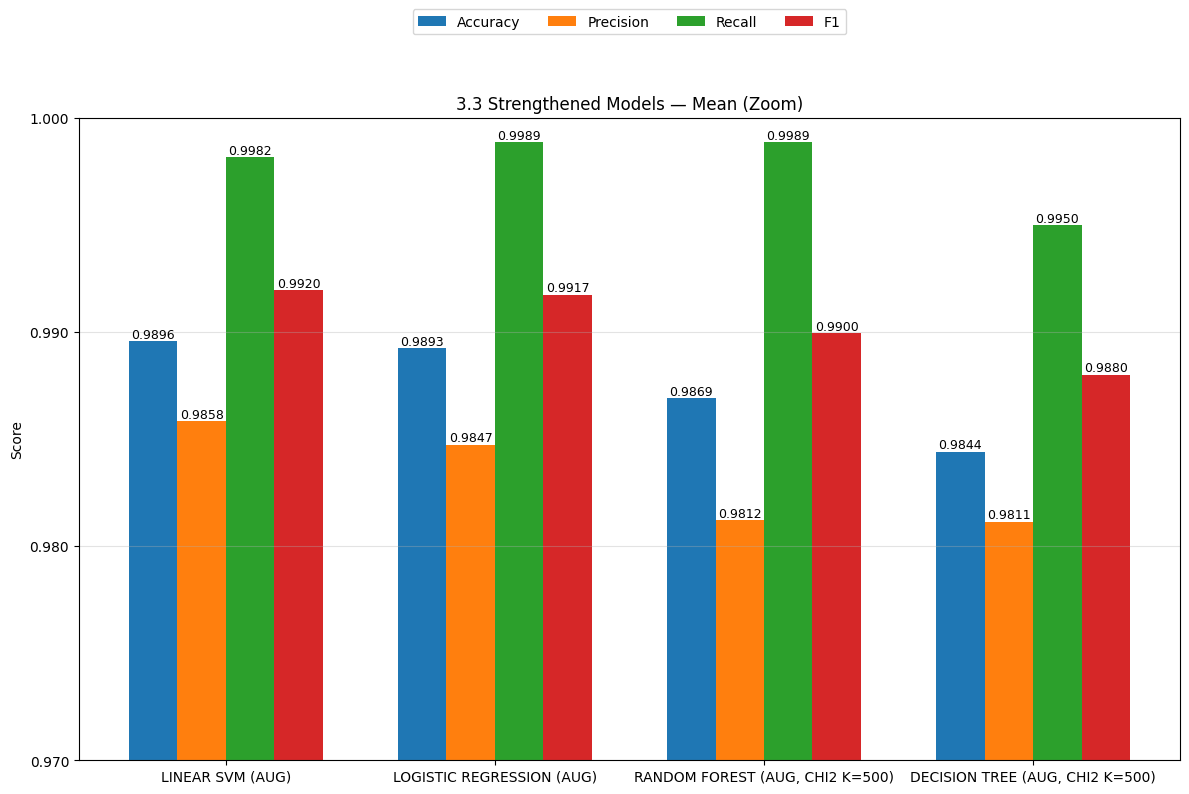

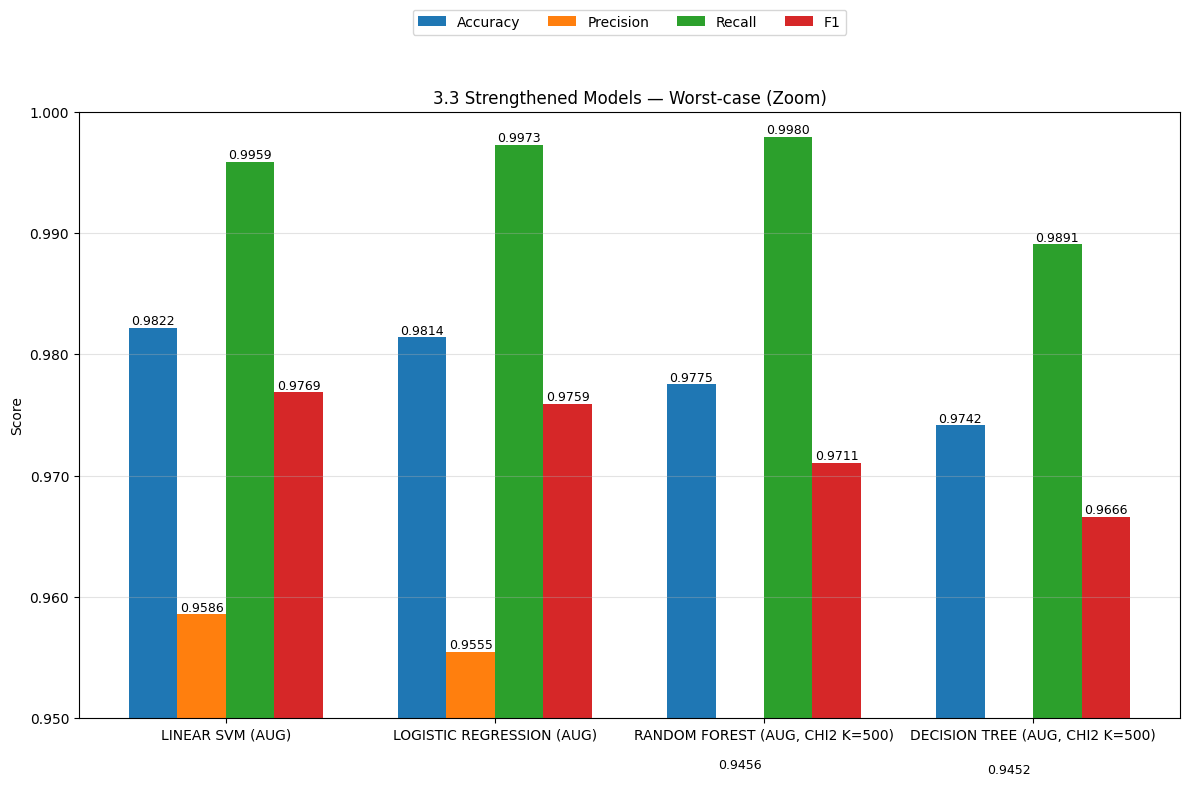

In [7]:
# ----------------------------
# 5) Plots like Section 3.1 (grouped bars)
# ----------------------------
def plot_grouped_metrics(df, metric_cols, metric_labels, title, out_path,
                         y_min=0.0, y_max=1.0, y_ticks=None, decimals=4):
    models = df["model"].tolist()
    data = df[metric_cols].to_numpy(dtype=float)

    x = np.arange(len(models))
    width = 0.18

    fig, ax = plt.subplots(figsize=(12, 8))
    for i, lab in enumerate(metric_labels):
        vals = data[:, i]
        bars = ax.bar(x + (i - 1.5) * width, vals, width, label=lab)
        for b, v in zip(bars, vals):
            ax.text(b.get_x() + b.get_width()/2, v, f"{v:.{decimals}f}",
                    ha="center", va="bottom", fontsize=9, rotation=0)

    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in models], fontsize=10)
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.set_ylim(y_min, y_max)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f"{t:.3f}" for t in y_ticks])
    ax.grid(axis="y", alpha=0.35)
    ax.legend(loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.18))
    fig.tight_layout()
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()

metric_cols=["acc","prec","rec","f1"]
metric_labels=["Accuracy","Precision","Recall","F1"]

plot_grouped_metrics(df_mean, metric_cols, metric_labels,
    "3.3 Strengthened Models — Mean over Obfuscated Variants",
    "./report_3_3/3_3_strengthened_mean_metrics.png",
    y_min=0.0, y_max=1.0, y_ticks=[0,0.2,0.4,0.6,0.8,1.0])

plot_grouped_metrics(df_worst, metric_cols, metric_labels,
    "3.3 Strengthened Models — Worst-case Robustness",
    "./report_3_3/3_3_strengthened_worst_metrics.png",
    y_min=0.0, y_max=1.0, y_ticks=[0,0.2,0.4,0.6,0.8,1.0])

# zoom versions (optional)
plot_grouped_metrics(df_mean, metric_cols, metric_labels,
    "3.3 Strengthened Models — Mean (Zoom)",
    "./report_3_3/3_3_strengthened_mean_metrics_zoom.png",
    y_min=0.97, y_max=1.0, y_ticks=[0.97,0.98,0.99,1.0])

plot_grouped_metrics(df_worst, metric_cols, metric_labels,
    "3.3 Strengthened Models — Worst-case (Zoom)",
    "./report_3_3/3_3_strengthened_worst_metrics_zoom.png",
    y_min=0.95, y_max=1.0, y_ticks=[0.95,0.96,0.97,0.98,0.99,1.0])
